<a href="https://colab.research.google.com/github/ArtificialT800/FoodModel/blob/main/yum_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import os
from tqdm.auto import tqdm
import requests
import zipfile
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

#Data

In [ ]:
data_path = Path("data/")
img_path = data_path / "food"

# If the image folder doesn't exist, download it and prepare it...
if img_path.is_dir():
    print(f"{img_path} directory exists.")
else:
    print(f"Did not find {img_path} directory, creating one...")
    img_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "data.zip", "wb") as f:
        request = requests.get("https://github.com/ArtificialT800/FoodModel/raw/main/food_101.zip")
        print("Downloading dataset...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "data.zip", "r") as zip_ref:
        print("Unzipping data...")
        zip_ref.extractall(img_path)

Did not find data/food directory, creating one...
Unzipping data...


##Train and test split

In [ ]:
train_dir = img_path / "train"
test_dir = img_path / "test"

train_dir, test_dir

(PosixPath('data/food/train'), PosixPath('data/food/test'))

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, #A transform for the data
                                  target_transform=None, #A transform for the labels/targets
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

print(train_data, test_data)

BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader)

Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data/food/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 750
    Root location: data/food/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


(141, 47)

In [ ]:
class_names = train_data.classes

In [ ]:
class CNNModel(nn.Module):
  def __init__(self, input_units, output_units, hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )
    self.block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

    self.block_4 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )
    self.block_5 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )


    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*229*229, out_features=output_units)

    )

  def forward(self, x):

    return self.Classifier(self.block_5(self.block_4(self.block_3(self.block_2(self.block_1(x))))))

model = CNNModel(input_units=3, hidden_units=10, output_units=len(class_names))
model = model.to(device)

##Loss function and optimizer + helper functions

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

def time_taken(start: float,
               end: float,
               device: torch.device = device):
  total_time = end-start
  return total_time


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start = timer()

EPOCHS = 100

results = {"train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": []
          }

for epoch in tqdm(range(EPOCHS)):
  #Training

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    train_acc += acc

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  #Testing
  model.eval()
  with torch.inference_mode():
    total_test_loss, total_test_acc = 0, 0
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model(X_test)

      test_loss = loss_fn(test_pred, y_test)
      total_test_loss += test_loss

      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
      total_test_acc += test_acc

    total_test_loss /= len(test_dataloader)
    total_test_acc /= len(test_dataloader)

    results["train_loss"].append(train_loss.to("cpu"))
    results["train_acc"].append(train_acc)
    results["test_loss"].append(total_test_loss.to("cpu"))
    results["test_acc"].append(total_test_acc)

  print(f"Epochs: {epoch}| Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}% | Test Loss: {total_test_loss:.4f}, Test Accuracy: {total_test_acc:.4f}%")


##Plotting Loss curves

In [ ]:
def plot_loss_curves(results):
  """Plots training curves of a trained model"""
  train_loss = results["train_loss"]
  total_test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  total_test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="Train Loss")

  plt.plot(epochs, total_test_loss, label="Test Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="Train Accuracy")
  plt.plot(epochs, total_test_acc, label="Test Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

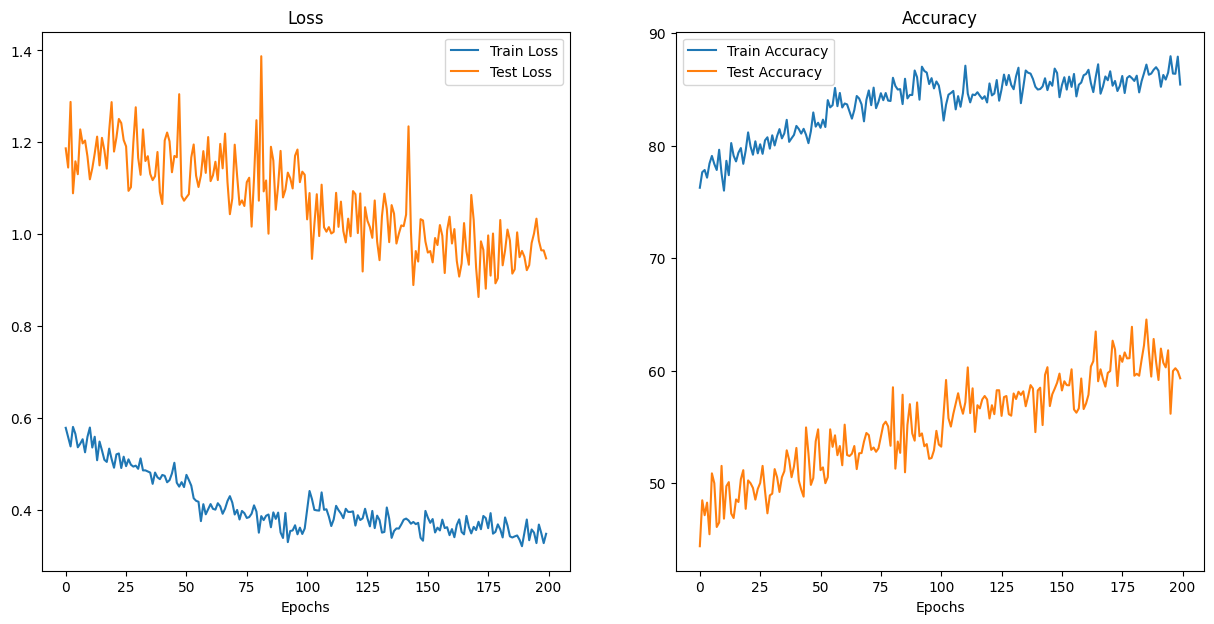

In [ ]:
plot_loss_curves(results=results)

#Predicting on new/custom images

In [ ]:
def plot_preds(model: torch.nn.Module):
  img_path = input("Enter the image path: ")
  img = torchvision.io.read_image(img_path)
  img = img.type(torch.float32) / 255
  img = img.to(device)
  img_transform = transforms.Compose([
      transforms.Resize(size=(224, 224))
  ])
  img = img_transform(img)
  img = img.unsqueeze(dim=0)

  model = model.to(device)
  model.eval()
  with torch.inference_mode():
    img_pred = model(img)
    img_pred_probs = torch.softmax(img_pred, dim=1)

  image = torch.argmax(img_pred_probs, dim=1).cpu()
  plt.figure(figsize=(12, 7))
  img = img.to("cpu")
  plot_img = img.squeeze()
  plt.imshow(plot_img.permute(1, 2, 0))
  plt.title(f"Pred: {class_names[image]} | Prob: {(img_pred_probs.max()):.4f}")
  plt.axis(False)

In [ ]:
plot_preds(model=model)

#Save the model if the accuracy is >= 85%

In [ ]:
if int(total_test_acc) >= 85:
  torch.save(obj=model.state_dict(), f='model.pt')

elif int(train_acc) >= 90:
  torch.save(obj=model.state_dict(), f='train_model.pt')
else:
  print("Accuracy isn't good enough...")
  print(f"Current Accuracy is: {total_test_acc:.3f}%")